In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        '''
        #Shared Encoder with credit given to SuperPoint original Authors
        SuperPoint: Self-Supervised Interest Point Detection and
        Description. Daniel DeTone, Tomasz Malisiewicz, and Andrew
        Rabinovich. In CVPRW, 2019. https://arxiv.org/abs/1712.07629
        '''
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1a = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2a = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4a = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv4b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        #Detector Head
        self.convPa = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.convPb = nn.Conv2d(256, 65, kernel_size=1, padding=0)
        #Descriptor Head
        self.convDa = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.convDb = nn.Conv2d(256, 256, kernel_size=1, padding=0)

    def forward(self, x):
        #Shared Encoder
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))

        #Detector Head
        cPa = self.relu(self.convPa(x))
        scores = self.convPb(cPa)

        #Descriptor Head
        cDa = self.relu(self.convDa(x))
        descriptors = self.convDb(cDa)
        descriptors = F.normalize(descriptors, p=2, dim=1)

        return scores, descriptors


In [3]:
def extract_keypoints_from_semi(semi, conf_threshold=0.015):
    heatmap = semi.squeeze().detach().cpu()
    heatmap = heatmap.softmax(dim=0)[:-1, :, :]
    heatmap = heatmap.permute(1, 2, 0)
    heatmap = heatmap.reshape(heatmap.shape[0], heatmap.shape[1], 8, 8)
    heatmap = heatmap.permute(0, 2, 1, 3)
    heatmap = heatmap.reshape(heatmap.shape[0]*8, heatmap.shape[2]*8)
    heatmap = heatmap.numpy()

    ys, xs = np.where(heatmap >= conf_threshold)
    confidences = heatmap[ys, xs]
    keypoints = np.stack([xs, ys], axis=-1)
    return keypoints, confidences


In [4]:
def load_image(path, device, resize=(640, 480)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error loading image at {path}")
        return None
    if resize:
        img = cv2.resize(img, resize)
    img = img.astype('float32') / 255.0
    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)
    return img


In [7]:
superpoint = SuperPointNet().to(device)
superpoint.load_state_dict(torch.load('//content/superpoint_v1.pth', map_location=device))
superpoint.eval()


<ipython-input-7-a38fae8a87b2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  superpoint.load_state_dict(torch.load('//content/superpoint_v1.pth', map_location=device))


SuperPointNet(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d

In [8]:
image_path1 = '/content/scene0738_00_frame-000885.jpg'
image_path2 = '/content/scene0738_00_frame-001065.jpg'

image1 = load_image(image_path1, device)
image2 = load_image(image_path2, device)



In [9]:
semi1, coarse_desc1 = superpoint(image1)
semi2, coarse_desc2 = superpoint(image2)


In [10]:
keypoints1, confidences1 = extract_keypoints_from_semi(semi1)
keypoints2, confidences2 = extract_keypoints_from_semi(semi2)

keypoints1_torch = torch.from_numpy(keypoints1).float().to(device).unsqueeze(0)  #(1, N, 2)
keypoints2_torch = torch.from_numpy(keypoints2).float().to(device).unsqueeze(0)  #(1, M, 2)


In [11]:
def sample_descriptors(descriptors, keypoints):

    b, c, h, w = descriptors.shape
    keypoints = keypoints.clone()

    # Normalize keypoints to [-1, 1]
    keypoints[..., 0] = (keypoints[..., 0] / (w - 1)) * 2 - 1 #width
    keypoints[..., 1] = (keypoints[..., 1] / (h - 1)) * 2 - 1 #height


    grid = keypoints.unsqueeze(1)
    grid = grid[..., [1, 0]]


    sampled_descriptors = F.grid_sample(descriptors, grid, mode='bilinear', align_corners=True)
    sampled_descriptors = sampled_descriptors.squeeze(2).permute(0, 2, 1)

    return sampled_descriptors



In [16]:
descriptors1 = sample_descriptors(coarse_desc1, keypoints1_torch)
descriptors2 = sample_descriptors(coarse_desc2, keypoints2_torch)


In [18]:
def visualize_keypoints(image_path, keypoints, resize=(640, 480)):
    img = cv2.imread(image_path)
    if resize:
        img = cv2.resize(img, resize)
    for kp in keypoints:
        x, y = kp
        cv2.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


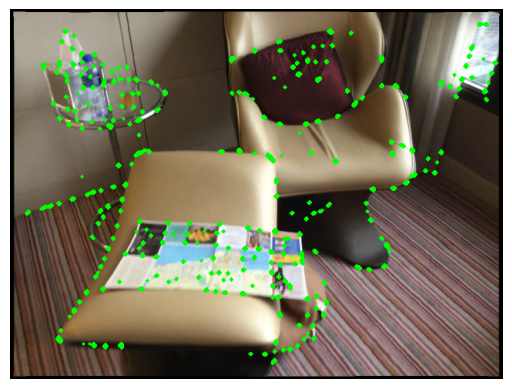

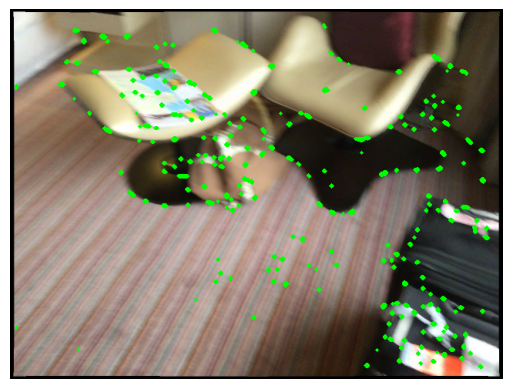

In [19]:
visualize_keypoints(image_path1, keypoints1, resize=(640, 480))
visualize_keypoints(image_path2, keypoints2, resize=(640, 480))


In [94]:
def normalize_keypoints(kpts, image_shape):
    _, _, height, width = image_shape
    size = torch.tensor([width, height], device=kpts.device).float().unsqueeze(0).unsqueeze(0)
    center = size / 2
    scaling = size.max(dim=2, keepdim=True).values * 0.7


    coords = kpts[..., :2]
    scores = kpts[..., 2:]

    coords_norm = (coords - center) / scaling

    kpts_norm = torch.cat([coords_norm, scores], dim=-1)

    return kpts_norm


In [93]:
class KeypointEncoder(nn.Module):
    def __init__(self, feature_dim, layers):
        super(KeypointEncoder, self).__init__()
        self.encoder = nn.Sequential()
        dims = [3] + layers + [feature_dim]
        for i in range(len(dims) - 1):
            self.encoder.add_module(
                f"{i}",
                nn.Sequential(
                    nn.Linear(dims[i], dims[i + 1]),
                    nn.ReLU(inplace=True)
                )
            )

    def forward(self, kpts):
        return self.encoder(kpts)


In [71]:
class MultiHeadAttention(nn.Module):
    def __init__(self, feature_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = feature_dim // num_heads
        assert feature_dim % num_heads == 0,
        self.scale = self.head_dim ** -0.5

        self.q_proj = nn.Linear(feature_dim, feature_dim)
        self.k_proj = nn.Linear(feature_dim, feature_dim)
        self.v_proj = nn.Linear(feature_dim, feature_dim)
        self.out_proj = nn.Linear(feature_dim, feature_dim)

    def forward(self, q, k, v):
        batch_size = q.shape[0]

        q = self.q_proj(q).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(k).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(v).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)


        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = F.softmax(scores, dim=-1)


        out = torch.matmul(attn, v)


        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        return self.out_proj(out)

In [72]:
class SelfAttention(nn.Module):
    def __init__(self, feature_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.mha = MultiHeadAttention(feature_dim, num_heads)
        self.norm = nn.LayerNorm(feature_dim)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 2),
            nn.ReLU(),
            nn.Linear(feature_dim * 2, feature_dim),
        )
        self.norm2 = nn.LayerNorm(feature_dim)

    def forward(self, x):
        x = x + self.mha(x, x, x)
        x = self.norm(x)
        x = x + self.mlp(x)
        x = self.norm2(x)
        return x

In [48]:
class CrossAttention(nn.Module):
    def __init__(self, feature_dim, num_heads):
        super(CrossAttention, self).__init__()
        self.mha = MultiHeadAttention(feature_dim, num_heads)
        self.norm = nn.LayerNorm(feature_dim)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim * 2),
            nn.ReLU(),
            nn.Linear(feature_dim * 2, feature_dim),
        )
        self.norm2 = nn.LayerNorm(feature_dim)

    def forward(self, x, context):
        x = x + self.mha(x, context, context)
        x = self.norm(x)
        x = x + self.mlp(x)
        x = self.norm2(x)
        return x

In [73]:
class AttentionalPropagation(nn.Module):
    def __init__(self, feature_dim, num_heads):
        super(AttentionalPropagation, self).__init__()
        self.attn = MultiHeadAttention(feature_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, feature_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feature_dim, feature_dim)
        )
        self.norm1 = nn.LayerNorm(feature_dim)
        self.norm2 = nn.LayerNorm(feature_dim)

    def forward(self, x, source):
        message = self.attn(x, source, source)
        x = self.norm1(x + message)
        x = self.norm2(x + self.mlp(x))
        return x

In [82]:
class SuperGlue(nn.Module):
    def __init__(self, config):
        super(SuperGlue, self).__init__()
        self.config = config
        self.kenc = KeypointEncoder(
            config['descriptor_dim'],
            layers=config['keypoint_encoder']
        )
        self.gnn = nn.ModuleList([
            AttentionalPropagation(
                config['descriptor_dim'], config['num_heads']
            ) for _ in range(config['GNN_layers'])
        ])

        self.final_proj = nn.Conv1d(config['descriptor_dim'], config['descriptor_dim'], kernel_size=1)

    def log_optimal_transport(self, scores, iters):
        b, m, n = scores.shape
        log_mu = torch.zeros((b, m), device=scores.device)
        log_nu = torch.zeros((b, n), device=scores.device)
        for _ in range(iters):
            log_mu = torch.logsumexp(scores, dim=2)
            scores = scores - log_mu.unsqueeze(2)
            log_nu = torch.logsumexp(scores, dim=1)
            scores = scores - log_nu.unsqueeze(1)
        return scores

    def forward(self, data):
        desc0, desc1 = data['descriptors0'], data['descriptors1']
        kpts0, kpts1 = data['keypoints0'], data['keypoints1']
        scores0, scores1 = data['scores0'], data['scores1']

        #Keypoint Encoder
        kpts0_enc = self.kenc(kpts0)
        kpts1_enc = self.kenc(kpts1)

        #Combine with descriptors
        desc0 = desc0 + kpts0_enc
        desc1 = desc1 + kpts1_enc

        #GNN Layers
        for layer in self.gnn:
            desc0 = layer(desc0, desc1)
            desc1 = layer(desc1, desc0)


        desc0 = desc0.permute(0, 2, 1)
        desc1 = desc1.permute(0, 2, 1)
        mdesc0 = self.final_proj(desc0)
        mdesc1 = self.final_proj(desc1)


        mdesc0 = mdesc0.permute(0, 2, 1)
        mdesc1 = mdesc1.permute(0, 2, 1)

        #Compute matching scores
        scores = torch.einsum('bdn,bdm->bnm', mdesc0, mdesc1)
        scores = scores / self.config['descriptor_dim'] ** 0.5

        #Sinkhorn normalization
        log_assignment = self.log_optimal_transport(scores, self.config['sinkhorn_iterations'])

        #Get matches
        max0, indices0 = log_assignment.max(dim=2)
        max1, indices1 = log_assignment.max(dim=1)

        mutual0 = torch.arange(indices0.shape[1], device=indices0.device).unsqueeze(0) == indices1.gather(1, indices0)
        matches0 = torch.where(mutual0, indices0, indices0.new_full(indices0.shape, -1))

        return {
            'matches0': matches0,
            'matching_scores0': torch.exp(max0)
        }
